In [1]:
import math
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy.stats import linregress
from scipy.fft import fft2, fftfreq
from scipy.io import savemat
from tqdm import tqdm
import re
import numdifftools.nd_algopy as nda

In [2]:
# Using natural units
# eps_0 = 1
# mu_0 = 1
# c = 1
# hbar = 1
# k_B = 1
# e = 1
# In SI units,
# c = 2.99792458e8 m/s
# hbar = 6.62607015e-34/(2*pi)
# k_B = 1.380649e-23 J/K
# mu_0 = 1.25663706212e-6 J/m/A^2 (experimental)
# 1 eV = 1.602176634e-19 J
# e = 1.602176634e-19 C
conversions = {
    "m/s": 2.99792458e8,
    "J*s": 6.62607015e-34/(2*np.pi),
    "J/K": 1.380649e-23,
    "J/m/A^2": 1.25663706212e-6,
    "J": 1.602176634e-19,
    "eV": 1,
    "1": 1
}
conversions["s"] = conversions["J*s"] / conversions["J"]
conversions["m"] = conversions["m/s"] * conversions["s"]
conversions["kg"] = conversions["J"] / conversions["m/s"]**2
conversions["g"] = conversions["kg"] / 1000
conversions["A"] = np.sqrt(conversions["J"] / conversions["m"] / conversions["J/m/A^2"])
conversions["C"] = conversions["A"] * conversions["s"]
conversions["V"] = conversions["J"] / conversions["C"]
conversions["N"] = conversions["J"] / conversions["m"]
conversions["W"] = conversions["J"] / conversions["s"]
conversions["T"] = conversions["J"] / conversions["A"] / conversions["m"]**2 
conversions["K"] = conversions["J"] / conversions["J/K"]
conversions["F"] = conversions["C"] / conversions["V"]
conversions["Hz"] = 1/conversions["s"]
conversions["rad"] = 1

In [3]:
conversions

{'m/s': 299792458.0,
 'J*s': 1.0545718176461565e-34,
 'J/K': 1.380649e-23,
 'J/m/A^2': 1.25663706212e-06,
 'J': 1.602176634e-19,
 'eV': 1,
 '1': 1,
 's': 6.582119569509067e-16,
 'm': 1.9732698045930251e-07,
 'kg': 1.7826619216278975e-36,
 'g': 1.7826619216278975e-39,
 'A': 0.0008038167088922266,
 'C': 5.290817689897897e-19,
 'V': 0.30282212087162635,
 'N': 8.119399740829861e-13,
 'W': 0.00024341348057879472,
 'T': 0.005118944531529093,
 'K': 11604.518121550082,
 'F': 1.747170145519456e-18,
 'Hz': 1519267447878626.0,
 'rad': 1}

In [4]:
prefixes = {
    'G': 1e9,
    'M': 1e-6,
    'k': 1e-3,
    'd': 1e1,
    'c': 1e2,
    'm': 1e3,
    'u': 1e6,
    'μ': 1e6,
    'p': 1e9
}
def get_conversion(unit):
    if unit in conversions:
        return conversions[unit]
    prefix, unit = unit[0], unit[1:]
    if prefix in prefixes and unit in conversions:
        return prefixes[prefix]*conversions[unit]
def conversion_ratio(unit):
    parts = re.split("([*/])", unit)
    conversion = 1
    previous = "*"
    for part in parts:
        result = 1
        if previous in ["*", "/"]:
            if '^' in part:
                left, right = part.split("^")
                result = get_conversion(left)**int(right)
            else:
                result = get_conversion(part)
            if previous == "/":
                result = 1/result
            conversion *= result
        previous = part
    return conversion
def to(unit, val):
    return val * conversion_ratio(unit)
def fr(unit, val):
    return val / conversion_ratio(unit)

In [5]:
num_points = 10000
# 1% per meter
e = fr("C", 1.602176634e-19)
c = 1
m = fr("eV", 5.1099906e5)
E_0 = fr("V/m", np.array([0, 0, 0]))
gE_r = lambda r: fr("V/m/m", np.array([0, 0, 0]))
E_r = lambda r: E_0
B_0 = fr("T", np.array([1, 0, 0]))
gB_r = lambda r: fr("1/m", -B_0/100)
B_r = lambda r: B_0 + gB_r(r) * r
t_span = (0, fr("us", 1))
p0 = fr("MeV", np.array([10, 10, 10])/np.sqrt(3))
r0 = fr("m", np.array([0, 0, 0]))
rtol = 1e-5 # = 0.001%
p_atol = fr("keV", 1)
r_atol = fr("cm", 1)
atol = np.array([p_atol, p_atol, p_atol, r_atol, r_atol, r_atol])
t_eval = np.linspace(*t_span, num_points) # 10000 points inside t_span

In [6]:
def gamma(p):
    return math.sqrt(1 + np.linalg.norm(p)**2/(m**2 * c**2))
def lorentz(r, v):
    return e * (E_r(r) + np.cross(v/c, B_r(r)))
def old_f0(r, v, l, gv):
    return - 2/3 * e**2 / c * v * gv**2 / m**2 / c**6 * [np.dot(l, l) - e**2 * np.dot(v, E_r(r))**2]
def f0(r, v, l, gv):
    pEdt = 0
    pBdt = 0
    first = pEdt + v * gE_r(r) + np.cross(v/c, pBdt + v * gB_r(r))
    second = np.cross(E_r(r), B_r(r)) + np.cross(B_r(r), np.cross(B_r(r), v/c)) + E_r(r) * np.dot(v/c, E_r(r))
    third = v * (np.dot(l, l) - e**2 * np.dot(E_r(r), v/c)**2)
    return (2*e**3)/(m*c**3) * gv * first + (2*e**4)/(3*m**2*c**4) * second - (2*e**2)/(3*m**2*c**5) * gv**2 * third
def fun(t, y):
    p, r = np.split(y, 2)
    gv = gamma(p)
    v = p / (m * gv)
    l = lorentz(r, v)
    f = f0(r, v, l, gv)
    dpdt = l + f
    drdt = v
    return np.concatenate([dpdt, drdt])
def plot(ax, u, label_u, unit_u, c=None, label_c=None, unit_c=None):
    u = to(unit_u, u)
    if c is not None:
        if unit_c is not None:
            c = to(unit_c, c)
        if u.ndim > 1 and u.shape[0] > 1:
            sc = ax.scatter(*u, c=c, cmap="hot", marker=".", s=1)
            ax.set_xlabel(f"{label_u}_x ({unit_u})")
            ax.set_ylabel(f"{label_u}_y ({unit_u})")
            if u.shape[0] > 2:
                ax.set_zlabel(f"{label_u}_z ({unit_u})")
                plt.colorbar(sc, ax=ax, location="bottom", shrink=0.5, pad=0.01, label=f"{label_c} ({unit_c})")
            else:
                plt.colorbar(sc, ax=ax, location="bottom", pad=0.1, label=f"{label_c} ({unit_c})")
        else:
            if u.ndim > 1:
                u = u[0]
            ax.scatter(c, u, marker=".", s=1)
            ax.set_xlabel(f"{label_c} ({unit_c})")
            ax.set_ylabel(f"{label_u} ({unit_u})")
    else:
        if u.ndim > 1 and u.shape[0] > 1:
            sc = ax.scatter(*u, marker=".", s=1)
            ax.set_xlabel(f"{label_u}_x ({unit_u})")
            ax.set_ylabel(f"{label_u}_y ({unit_u})")
            if u.shape[0] > 2:
                ax.set_zlabel(f"{label_u}_z ({unit_u})")
    return ax
def run(fun, t, y, progress):
    progress.n = to("us", t)
    progress.update(0)
    return fun(t, y)
def linear_fit(x, y, x_label="x", y_label="y", units=""):
    fit, cov = np.polyfit(x, y, 1, cov=True)
    uncertainty = np.sqrt(np.diag(cov))
    f = np.poly1d(fit)
    print(f"{y_label} = {fit[0]:.3}±{uncertainty[0]:.3} {x_label} + {fit[1]:.3}±{uncertainty[1]:.3} {units}")
    return f

In [7]:
y0 = np.concatenate([p0, r0])
with tqdm(total=to("us", t_span[1]), position=to("us", t_span[0]), bar_format='{l_bar}{bar}| {n_fmt:.5}us/{total_fmt:.5}us [{elapsed}<{remaining}, ' '{rate_fmt}{postfix}]', unit="us") as progress:
    sol = solve_ivp(lambda t, y: run(fun, t, y, progress), t_span, y0, method="RK45", t_eval=t_eval, dense_output=True, rtol=rtol, atol=atol)

100%|███████████████████████████████████████████████████████████████████████████████████| 1.0us/1.0us [00:31<00:00, 31.93s/us]


In [8]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 47870
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x000001F032315AF0>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.51941939e+05, 3.03883878e+05, ...,
       1.51896356e+09, 1.51911551e+09, 1.51926745e+09])
 t_events: None
        y: array([[ 5.77350269e+06,  5.77350267e+06,  5.77350266e+06, ...,
         5.77347131e+06,  5.77347131e+06,  5.77347131e+06],
       [ 5.77350269e+06,  8.11431937e+06,  4.34152840e+06, ...,
        -5.26763779e+05,  1.25000408e+06, -6.86202971e+05],
       [ 5.77350269e+06, -9.15574952e+05, -6.91385300e+06, ...,
        -1.13744047e+06,  9.12114765e+04,  1.04802010e+06],
       [ 0.00000000e+00,  8.76310535e+04,  1.75194103e+05, ...,
         1.20051869e+09,  1.20066665e+09,  1.20081461e+09],
       [ 0.00000000e+00,  1.13083342e+05,  2.14504484e+05, ...,
         7.59540873e+06,  7.61057796e+06,  7.62239

In [9]:
t = sol.t
y = sol.y
p, r = np.split(y, 2)

In [10]:
v = p / (m * gamma(p))
r_corr = r - np.tile(np.mean(r, axis=1), (r.shape[1],1)).T
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = np.cross(r_corr, v_corr, axis=0)/np.linalg.norm(r_corr[1:], axis=0)**2
beta_perp = np.linalg.norm(v_corr[1:], axis=0)/c
beta = np.linalg.norm(v_corr, axis=0)/c
power = 2*(e*omega[0])**2/(3*c)*(beta_perp**2)/(1 - beta**2)
frequency = 2 * np.pi * np.abs(omega[0])
period = 1/frequency
B = np.apply_along_axis(B_r, 0, r)
E = np.apply_along_axis(E_r, 0, r)

In [11]:
standard_figsize = (8, 6)
square_figsize = (7.5, 10)
double_square_figsize = (15, 10)
large_standard_figsize = (16, 12)

<Axes3DSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

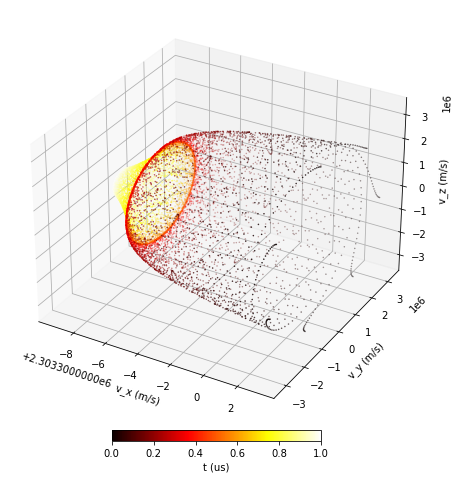

In [12]:
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw=dict(projection="3d"))
plot(ax, v, "v", "m/s", t, "t", "us")

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

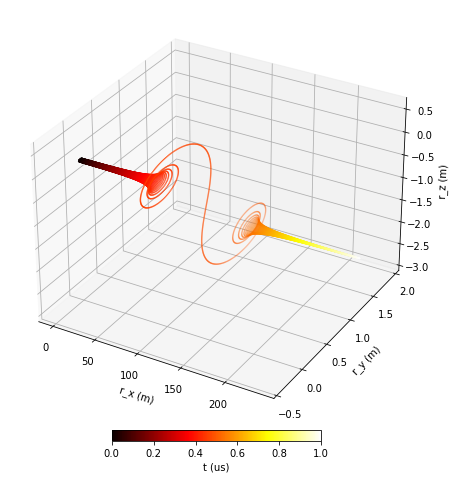

In [13]:
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw=dict(projection="3d"))
plot(ax, r, "r", "m", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='p (kg*m/s)'>

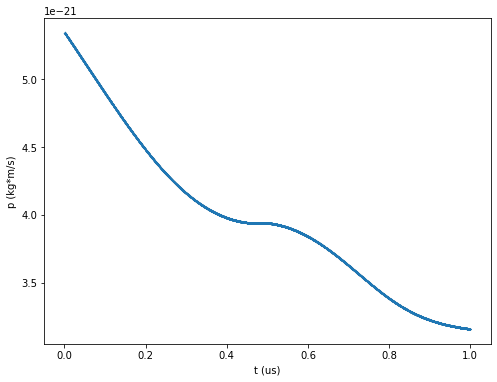

In [14]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(p, axis=0), "p", "kg*m/s", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='E (eV)'>

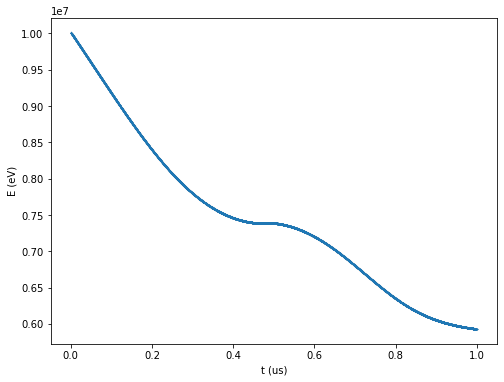

In [15]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.sqrt(np.linalg.norm(p, axis=0)**2 + (m*c**2)**2), "E", "eV", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='r (m)'>

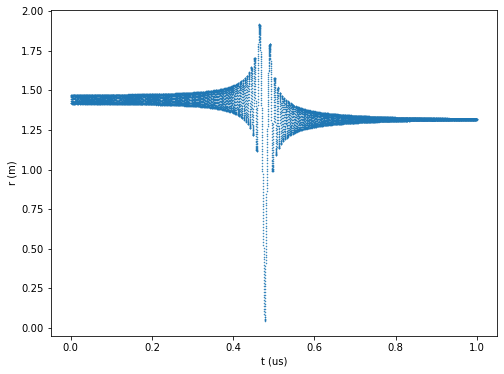

In [16]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(r_corr[1:], axis=0), "r", "m", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='v (m/s)'>

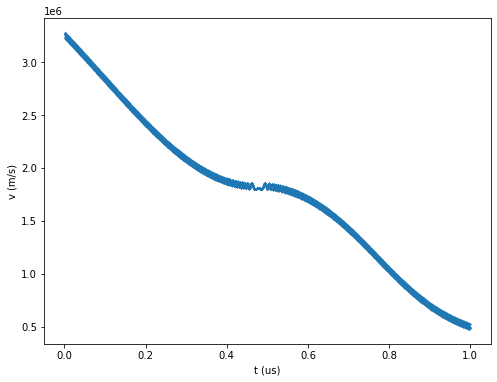

In [17]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), np.linalg.norm(v_corr[1:], axis=0), "v", "m/s", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='f (Hz)'>

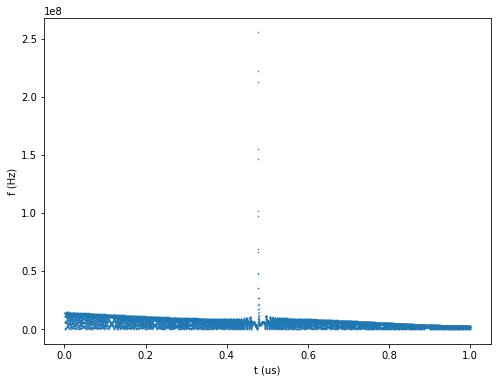

In [18]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), frequency, "f", "Hz", t, "t", "us")
# plt.yscale("log")

<AxesSubplot:xlabel='t (us)', ylabel='T (us)'>

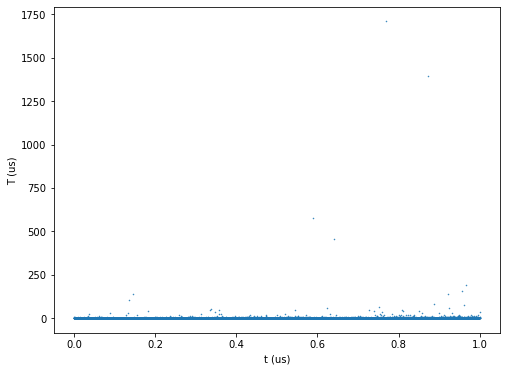

In [19]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), period, "T", "us", t, "t", "us")
# plt.yscale("log")

<AxesSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

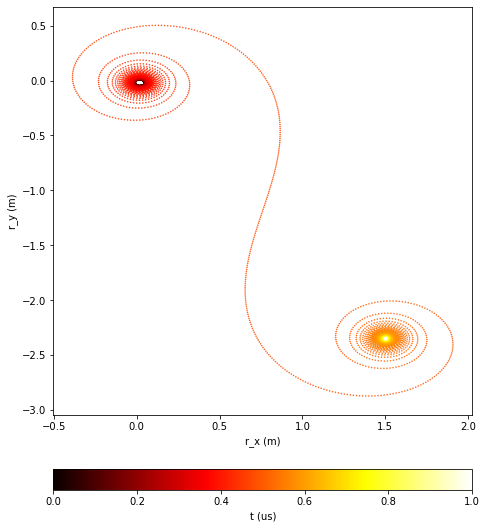

In [20]:
plt.figure(figsize=square_figsize)
plot(plt.axes(), r[1:], "r", "m", t, "t", "us")

<AxesSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

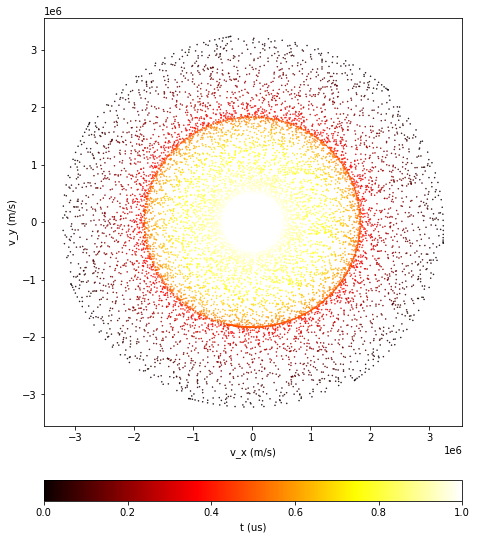

In [21]:
plt.figure(figsize=square_figsize)
plot(plt.axes(), v[1:], "v", "m/s", t, "t", "us")

<AxesSubplot:xlabel='t (us)', ylabel='P (W)'>

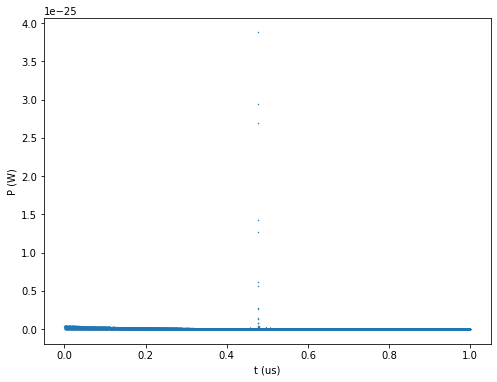

In [22]:
plt.figure(figsize=standard_figsize)
plot(plt.axes(), power, "P", "W", t, "t", "us")
# plt.yscale("log")

In [23]:
def G(a, b, theta):
    cs = np.cos(theta)
    sn = np.sin(theta)
    g = 1 - a * cs
    top = 4*g**2 * ((1+a**2) * (1+cs**2) - 4*a*cs) - (1 - a**2 + 3 * b**2) * b**2 * sn**4
    bottom = 4 * (g**2 - (b**2) * (sn**2))**3.5
    F = top/bottom
    return 3/4 * (1 - (a**2 + b**2))**2 * F

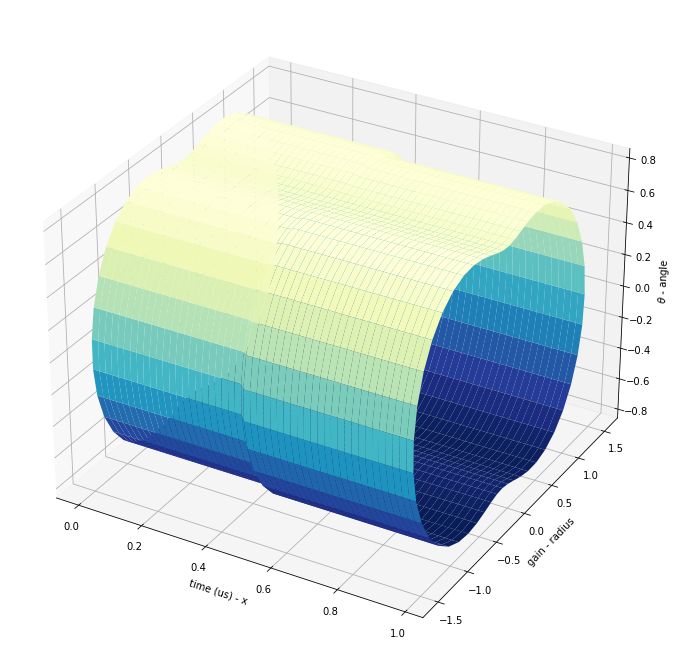

In [24]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
every_n = 200
t_plot = t[::every_n]
beta =v/c
bll = (np.sum(beta*B, 0)/np.linalg.norm(B, axis=0))[::every_n]
bperp = np.sqrt((np.linalg.norm(beta, axis=0)**2)[::every_n] - bll**2)
p = np.linspace(0, 2*np.pi, 50)
T, P = np.meshgrid(t_plot, p)
R = G(bll, bperp, P)
X, Y = R*np.cos(P), R*np.sin(P)
Z = T
ax.plot_surface(to("us",Z), X, Y, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("time (us) - x")
ax.set_ylabel("gain - radius")
ax.set_zlabel("$\\theta$ - angle")
plt.show()

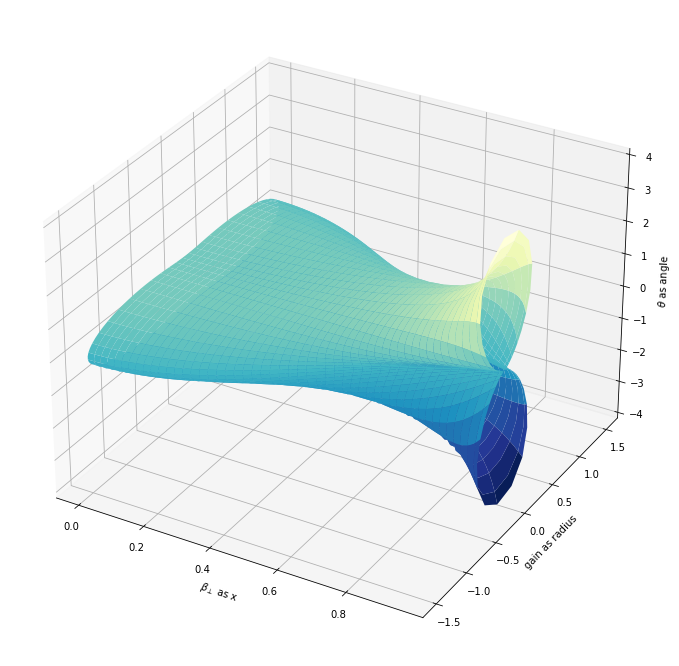

In [25]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
b = np.linspace(0, 0.95, 100)
p = np.linspace(0, 2*np.pi, 100)
B, P = np.meshgrid(b, p)
R = G(0, B, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

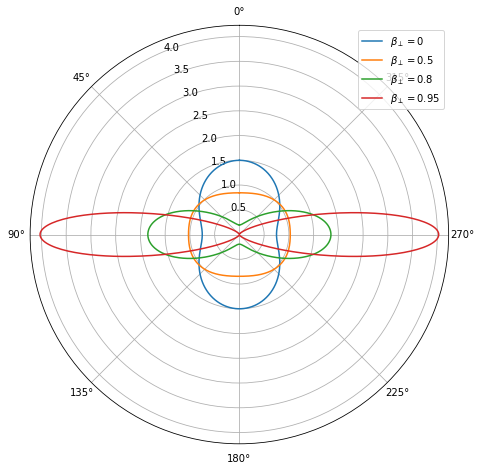

In [26]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for bperp in [0, 0.5, 0.8, 0.95]:
    ax.plot(theta, G(0, bperp, theta), label="$\\beta_{\perp} = " + str(bperp) + "$")
plt.legend()
ax.grid(True)
plt.show()

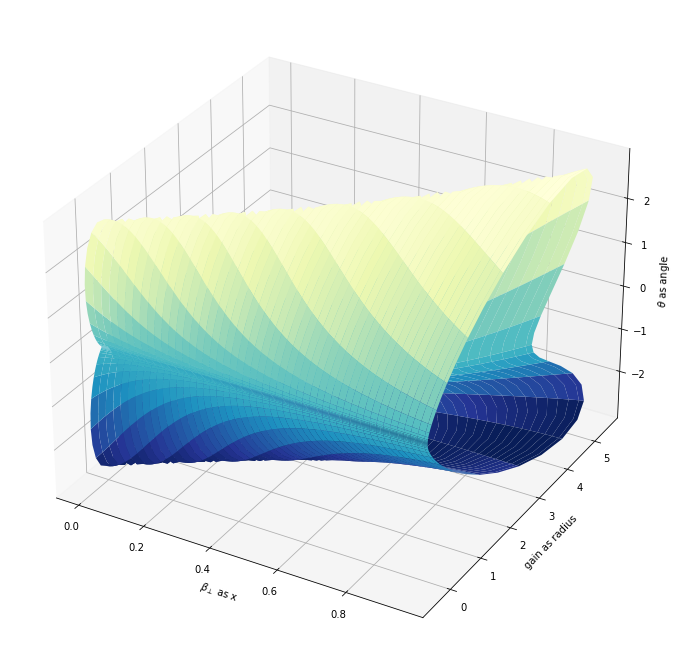

In [27]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
r = np.linspace(0, 1.5, 100)
p = np.linspace(0, 2*np.pi, 100)
ratio, P = np.meshgrid(r, p)
bperp = 0.9/np.sqrt(ratio**2 + 1)
bll = bperp*ratio
R = G(bll, bperp, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

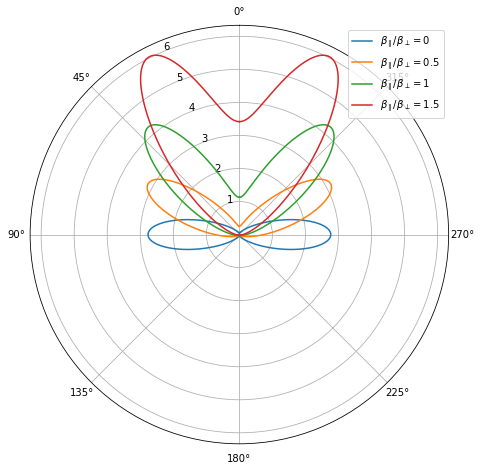

In [28]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for ratio in [0, 0.5, 1, 1.5]:
    bperp = 0.9/np.sqrt(ratio**2 + 1)
    bll = bperp*ratio
    ax.plot(theta, G(bll, bperp, theta), label="$\\beta_{\parallel} / \\beta_{\perp} = " + str(ratio) + "$")
plt.legend()
ax.grid(True)
plt.show()

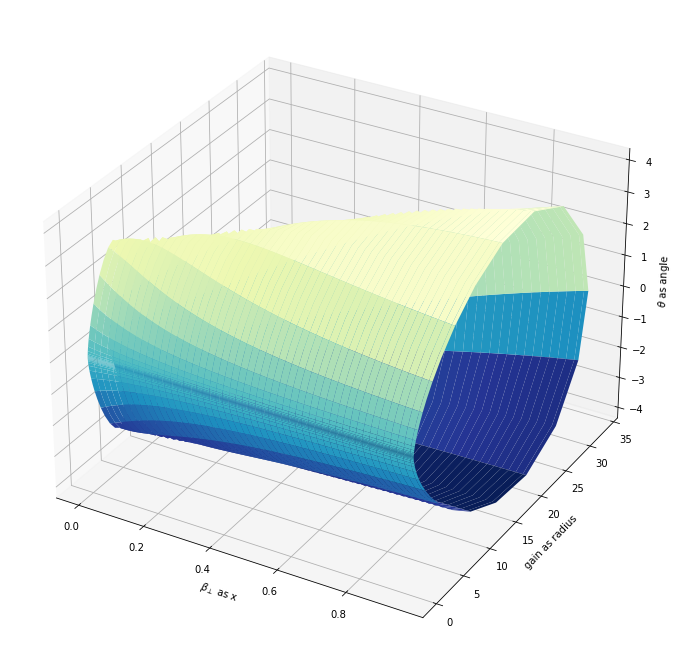

In [29]:
fig, ax = plt.subplots(figsize=large_standard_figsize, subplot_kw={'projection': '3d'})
r = np.linspace(1.5, 5, 100)
p = np.linspace(0, 2*np.pi, 100)
ratio, P = np.meshgrid(r, p)
bperp = 0.9/np.sqrt(ratio**2 + 1)
bll = bperp*ratio
R = G(bll, bperp, P)
X = B
Y, Z = R*np.cos(P), R*np.sin(P)
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
ax.set_xlabel("$\\beta_{\perp}$ as x")
ax.set_ylabel("gain as radius")
ax.set_zlabel("$\\theta$ as angle")
plt.show()

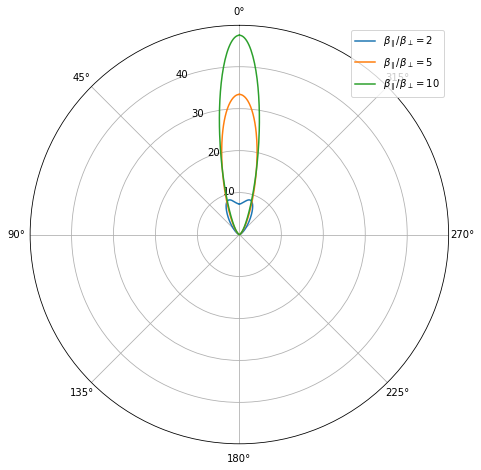

In [30]:
theta = np.linspace(0, 2*np.pi, 1000)
fig, ax = plt.subplots(figsize=square_figsize, subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location("N")
for ratio in [2, 5, 10]:
    bperp = 0.9/np.sqrt(ratio**2 + 1)
    bll = bperp*ratio
    ax.plot(theta, G(bll, bperp, theta), label="$\\beta_{\parallel} / \\beta_{\perp} = " + str(ratio) + "$")
plt.legend()
ax.grid(True)
plt.show()